<a href="https://colab.research.google.com/github/SamerHasn/Applied-Econometric-Time-Series-4th-Edition-Walter-Enders/blob/master/Chapter_3_Modeling_Volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

<b>Applied Econometric Time Series</b><br/>
<b>Chapter 3: Modeling Volatility</b> 
<br/>
4th Edition 
<br/>
<br/> <b>Walter Enders</b>
<br/>
<br/> Coded by:
<br/> 
[Samer Hasn](https://www.linkedin.com/in/samerhasn/)

</center>


# **1. Installing and Loading Packages and Data**

In [ ]:
install.packages("texreg")    # To organize models summary
install.packages("forecast")  # For ACF/PACF Calc.
install.packages("gridExtra") # To equivalently edit the graphical parameter mfrow() by par() for ggplot2
install.packages("rugarch")   # For GARCH models
install.packages("garchx")    # For simple ARCH/GARCH processes simulation
install.packages("dynlm")     # To conduct a manual ARCH test

library(texreg)
library(ggplot2)
library(readxl)
library(gridExtra)
library(rugarch)
library(zoo)
library(garchx)
library(dynlm)

In [33]:
# Downloading "quarterly" Data

url <- "http://time-series.net/yahoo_site_admin/assets/docs/quarterly.7775706.xls"
destfile <- "quarterly.xls"
curl::curl_download(url, destfile)
quarterly <- read_excel(destfile)

# Downloading "Real" Data

url <- "http://time-series.net/yahoo_site_admin/assets/docs/Real.38134309.xls"
destfile <- "Real.xls"
curl::curl_download(url, destfile)
real <- read_excel(destfile)
real[,1] <- seq(as.Date("1947/1/1"), as.Date("2012/12/31"), by = "quarter")

# Downloading "NYSE U.S.100" Data

url <- "http://time-series.net/yahoo_site_admin/assets/docs/NYSEReturns.38135430.xlsx"
destfile <- "NYSEReturns.xlsx"
curl::curl_download(url, destfile)
nyse <- read_excel(destfile)

# Downloading "Exchange Rate" Data

url <- "http://time-series.net/yahoo_site_admin/assets/docs/ExRatesdaily.38134659.xls"
destfile <- "ExRates.xls"
curl::curl_download(url, destfile)
ExRates <- read_excel(destfile, 
    col_types = c("date", "numeric", "numeric", 
        "numeric"))

# Downloading "OIL" Data

url <- "http://time-series.net/yahoo_site_admin/assets/docs/oil.38135455.xls"
destfile <- "oil.xls"
curl::curl_download(url, destfile)
oil <- read_excel(destfile, col_types = c("date", 
    "numeric"))

In [34]:
# Multi-lags Ljung-Box Test Orginizer

  # Ljung-Box Test Info. Extractor
  
lb.test <- function(data ,lags = c(4,8,12),p.value=T,type = "Ljung-Box") {
 
  q <- data.frame(0,0)
 
  for(i in seq(c(4,8,12))){
 
    q[i,] <- c(Box.test(data,lags[i],type)$statistic, Box.test(data,lags[i],type)$p.value)
 
  }
 
names(q) <- c("statistic","p.value")
row.names(q) <- (sprintf("Q(%d)" ,lags))
 
return(q)
 
}
 
  # Ljung-Box Test Info. Union
 
lb.cat <- function(lb.test){
 
  qcat <- matrix(0,nrow = nrow(lb.test),ncol = 1)
 
  for(i in 1:nrow(lb.test)){
 
      qcat[i,] <- paste0(sprintf("%.2f (%.3f)",lb.test[i,1],lb.test[i,2]))
 
  }
 
  return(qcat)
 
}

In [35]:
# To customize rugarch with texreg packages. Many thanks to Emil at Stackoverflow. 
  # https://stackoverflow.com/questions/57312645/how-to-export-garch-output-to-latex

extract.rugarch <- function(fit,  
                            include.loglike = TRUE, include.aic = TRUE, 
                            include.bic = TRUE) 
{
  
  # extract coefficient table from fit:
  coefnames <- rownames(as.data.frame(fit@fit$coef))
  coefs <- fit@fit$coef
  se <- as.vector(fit@fit$matcoef[, c(2)])
  pvalues <-  as.vector(fit@fit$matcoef[, c(4)])       # numeric vector with p-values
  
  # create empty GOF vectors and subsequently add GOF statistics from model:
  gof <- numeric()
  gof.names <- character()
  gof.decimal <- logical()
  
  if (include.loglike == TRUE) {
    loglike <- fit@fit$LLH
    gof <- c(gof, loglike)
    gof.names <- c(gof.names, "Log likelihood")
    gof.decimal <- c(gof.decimal, TRUE)
  }
  if (include.aic == TRUE) {
    aic <- infocriteria(fit)[c(1)]
    gof <- c(gof, aic)
    gof.names <- c(gof.names, "AIC")
    gof.decimal <- c(gof.decimal, TRUE)
  }
  
  if (include.bic == TRUE) {
    bic <- infocriteria(fit)[c(2)]
    gof <- c(gof, bic)
    gof.names <- c(gof.names, "BIC")
    gof.decimal <- c(gof.decimal, TRUE)
  }
  
  # create texreg object:
  tr <- createTexreg(
    coef.names = coefnames, 
    coef = coefs,
    se = se,
    pvalues = pvalues, 
    gof.names = gof.names, 
    gof = gof, 
    gof.decimal = gof.decimal
  )
  return(tr)
}

In [36]:
# ggplot2 Theme Spec.

mytheme <- theme(
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  legend.position="bottom",
  axis.text = element_text(size = 12, face="bold"),
  plot.title = element_text(hjust = 0.5, face = "bold")
  )

In [37]:
# Plot two ACFs in one graph

myacf <- function(data.list, h = 8,y.breaks = seq(-.5,1,.25) ,
                  aspect.ratio = 1  ,title="",data.name=c("ACF1","ACF2") ,gtheme = theme()) {
  
  # Organizing Data
  
  acfs <- data.list
  acfs <- lapply(acfs,forecast::Acf,lag.max= h ,plot=F)
  acf1 <- cbind(cbind(acfs[[1]]$acf),data.name[1])
  acf2 <- cbind(cbind(acfs[[2]]$acf),data.name[2])
  acfs <- data.frame(rep(0:h,2),rbind(acf1,acf2))
  
  names(acfs) <- c("lag","acf","type")
  acfs <- acfs[-c(1,h+2),]
  
  twose <- c(2/sqrt(length(acf1)),- 2/sqrt(length(acf1)))

  # Plot Spec.
  
  ggplot(acfs ,aes(x = lag ,y = as.numeric(acf) ,fill = type))+
    geom_hline(yintercept=twose,linetype=2,color = "blue")+
    geom_bar(position = "dodge", stat = "identity")+
    scale_fill_grey(start = 0.2, end = 0.8) +
    labs(fill = "" ,y = "" ,x = "" ,title = title)+
    scale_x_continuous(breaks = c(0:h+1))+
    scale_y_continuous(breaks = y.breaks ,limits = c(y.breaks[1],y.breaks[length(y.breaks)]) ,
                       expand = c(0, 0))+
    theme_bw()+
    geom_line(y = 0)+
    theme(aspect.ratio = aspect.ratio)+
    gtheme
}

In [38]:
# Multi-lags Ljung-Box Test Orginizer

  # Ljung-Box Test Info. Extractor

lb.test <- function(data ,lags = c(4,8,12),p.value=T,type = "Ljung-Box") {

  q <- data.frame(0,0)

  for(i in seq(c(4,8,12))){

    q[i,] <- c(Box.test(data,lags[i],type)$statistic, Box.test(data,lags[i],type)$p.value)

  }

names(q) <- c("statistic","p.value")
return(q)

}

  # Ljung-Box Test Info. Union

lb.cat <- function(lb.test){

  qcat <- matrix(0,nrow = nrow(lb.test),ncol = 1)

  for(i in 1:nrow(lb.test)){

      qcat[i,] <- paste0(sprintf("%.2f (%.3f)",lb.test[i,1],lb.test[i,2]))

  }

  return(qcat)

}

# **2. Economic Time Series:the Stylized Facts**

Warning message:
“Removed 8 row(s) containing missing values (geom_path).”


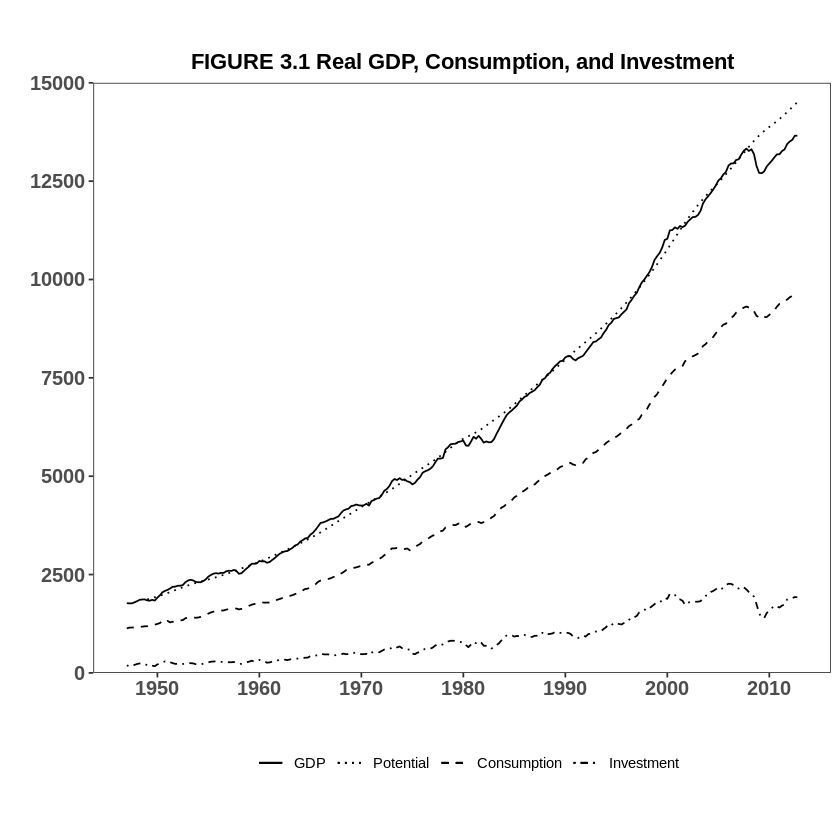

In [39]:
ggplot(real)+
   geom_line(aes(x=DATE ,y = Rinv ,linetype="solid"))+
   geom_line(aes(x=DATE ,y = RCons  ,linetype="dotted"))+
   geom_line(aes(x=DATE ,y = Potential ,linetype="dotdash"))+
   geom_line(aes(x=DATE ,y = RGDP ,linetype="dashed"))+
   
   scale_linetype_manual(values =c(1,3,2,4),name = ""
                        ,labels = c("GDP","Potential","Consumption","Investment"))+
   scale_x_continuous(name="" ,breaks = seq(as.Date("1950/1/1"), as.Date("2012/12/31"), by = "10 year"),
                     labels=as.character(seq(1950, 2010, 10)))+
   scale_y_continuous(name="" ,limits = c(0,15000), expand = c(0, 0),breaks = seq(0,15000,2500))+
   labs(title = "FIGURE 3.1 Real GDP, Consumption, and Investment")+

   theme_bw()+ 
   theme(aspect.ratio = .8)+
   mytheme

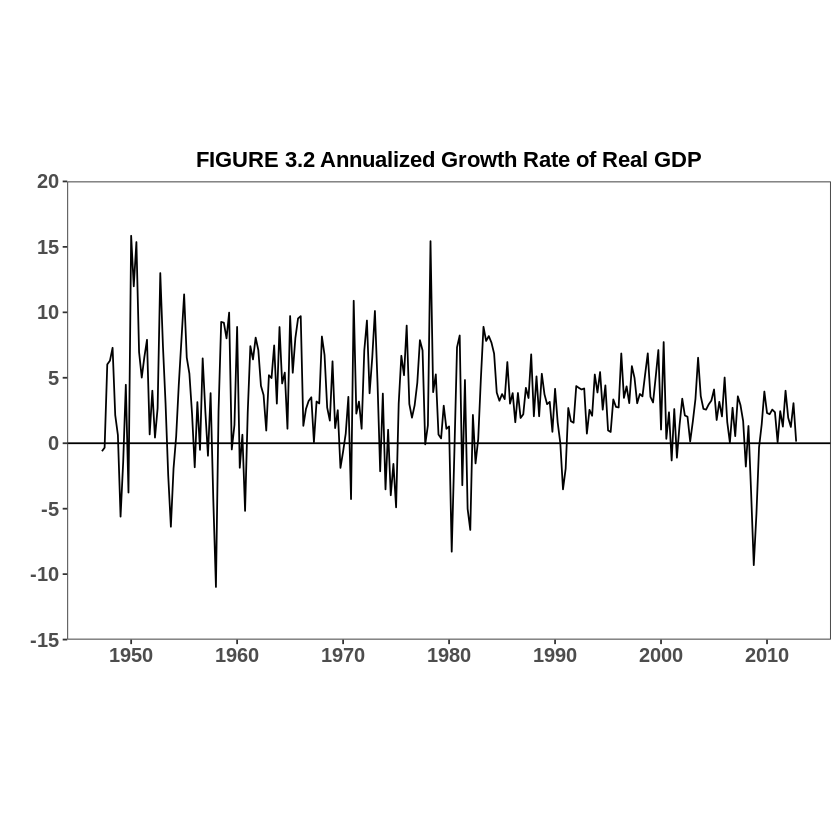

In [40]:
dgdp <- diff(log(real$RGDP)*400)
dgdp.date <- seq(as.Date("1947/4/1"), as.Date("2012/12/31"), by = "quarter")
dgdp <- data.frame(dgdp.date,dgdp)
ggplot(dgdp)+

   geom_line(aes(x=dgdp.date ,y = dgdp))+
   geom_hline(yintercept = 0)+
   
   scale_x_continuous(name="" ,breaks = seq(as.Date("1950/1/1"), as.Date("2012/12/31"), by = "10 year"),
                     labels=as.character(seq(1950, 2010, 10)))+
   scale_y_continuous(name="" ,limits = c(-15,20), expand = c(0, 0),breaks = seq(-15,20,5))+
   labs(x = "" ,y = "" ,title = "FIGURE 3.2 Annualized Growth Rate of Real GDP")+

   theme_bw()+
   theme(aspect.ratio = .6)+ 
   mytheme

Warning message in diff(log(as.numeric(nyse$RETURN)), 1):
“NAs introduced by coercion”


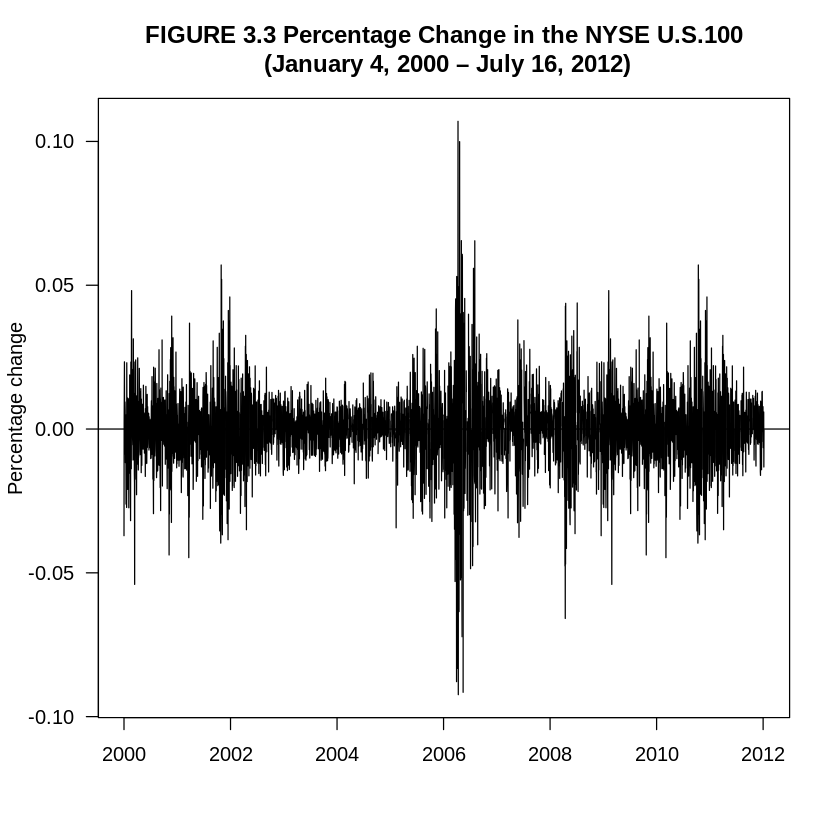

In [41]:
nyse.ts <- ts(diff(log(as.numeric(nyse$RETURN)) ,1 ), 
                start = c(2000,1), end = c(2012,7), frequency = 365)
                
plot(nyse.ts ,ylab= "Percentage change",xlab="" ,
        main = "FIGURE 3.3 Percentage Change in the NYSE U.S.100\n (January 4, 2000 – July 16, 2012)", las = 1) 
abline(h = 0)

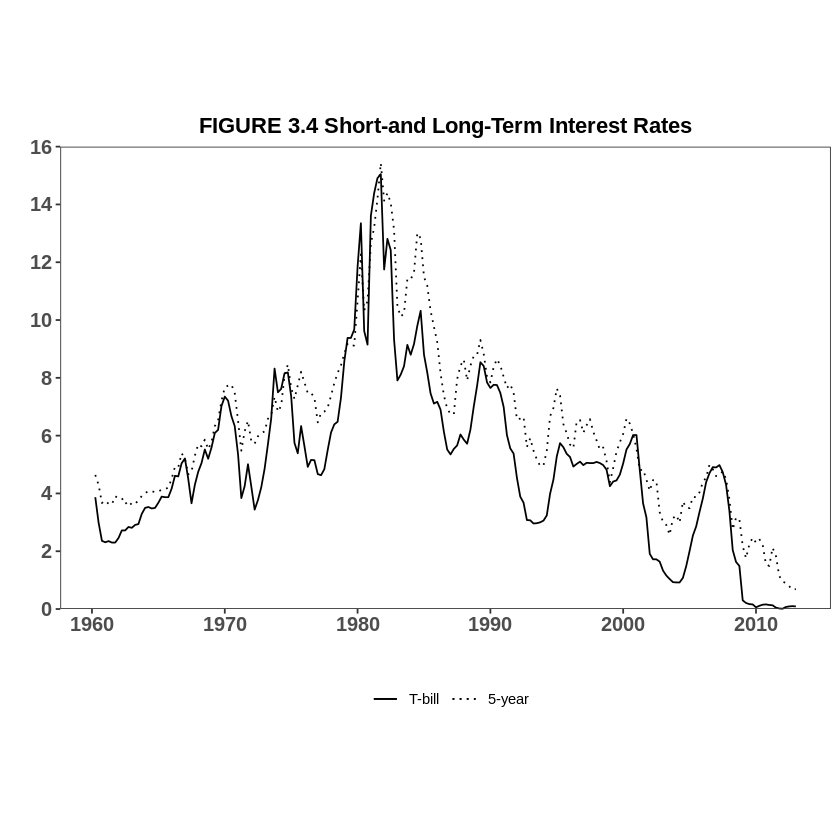

In [42]:
quarterly$DATE <- seq(as.Date("1960/4/1") , as.Date("2013/1/1") , by = "quarter")

ggplot(quarterly)+

   geom_line(aes(x=DATE ,y = Tbill, group =1, linetype="dotted"))+
   geom_line(aes(x=DATE ,y =r5, group =1, linetype="solid"))+

   scale_linetype_manual(values =c(1,3),name = ""
                        ,labels = c("T-bill","5-year"))+
  
   scale_x_continuous(name="" ,breaks = seq(as.Date("1960/1/1"), as.Date("2012/12/31"), by = "10 year"),
                      labels=as.character(seq(1960, 2010, 10)))+
   scale_y_continuous(name="" ,limits = c(0,16), expand = c(0, 0),breaks = seq(0,16,2))+
   labs(x = "" ,y = "" ,title = "FIGURE 3.4 Short-and Long-Term Interest Rates")+

   theme_bw()+
   theme(aspect.ratio = .6)+ 
   mytheme

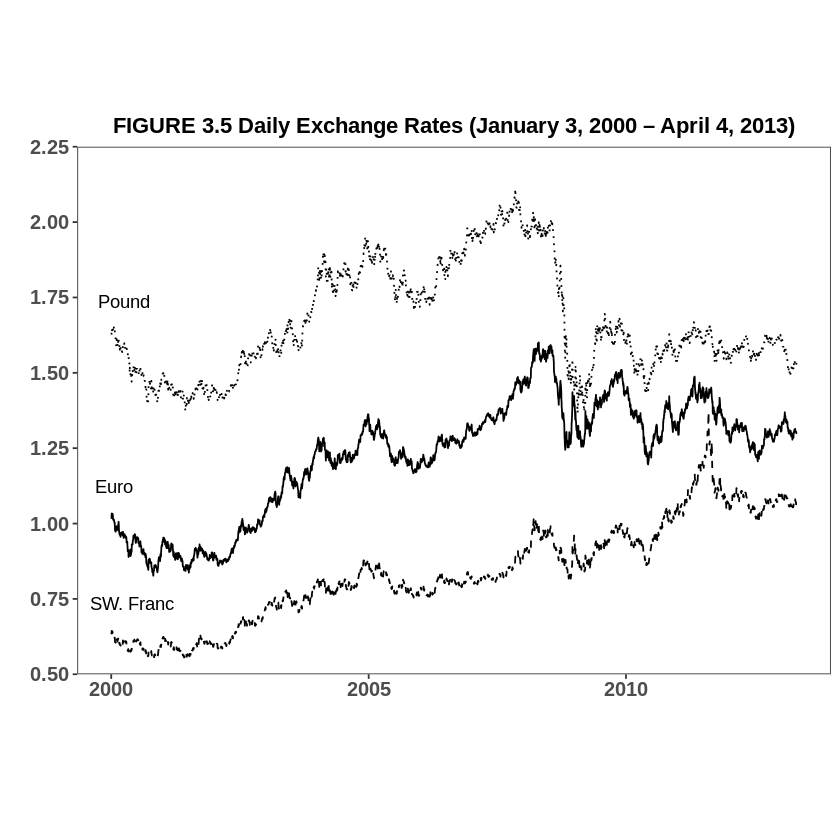

In [43]:
lables <- data.frame( x = ExRates[length(ExRates),1],
                      y = as.numeric(matrix(c(ExRates[length(ExRates),-c(1,4)],
                                                1/ExRates[length(ExRates),-c(1:3)]),3,1))
          )          
          
ggplot(ExRates)+

  geom_line(aes(x = observation_date ,y = Pound),linetype = "dotted")+
  geom_line(aes(x = observation_date ,y = Euro) ,linetype = "solid")+
  geom_line(aes(x = observation_date ,y = 1/SW) ,linetype = "dashed")+
  geom_text(data = lables ,aes(x=observation_date	,y=y),
    label=c(" Euro","     Pound","        SW. Franc"), 
    nudge_y = .09
  )+

 # scale_x_date(breaks = seq(as.Date("2000/1/1"), as.Date("2012/12/31"), by = "2 year"))+
  scale_y_continuous(name="" ,limits = c(.5,2.25) ,expand = c(0, 0) ,breaks = seq(.5,2.25,.25))+
  labs(x = "" ,y = "" ,title = "FIGURE 3.5 Daily Exchange Rates (January 3, 2000 – April 4, 2013)")+

  theme_bw()+
  theme(aspect.ratio = .7)+ 
  mytheme

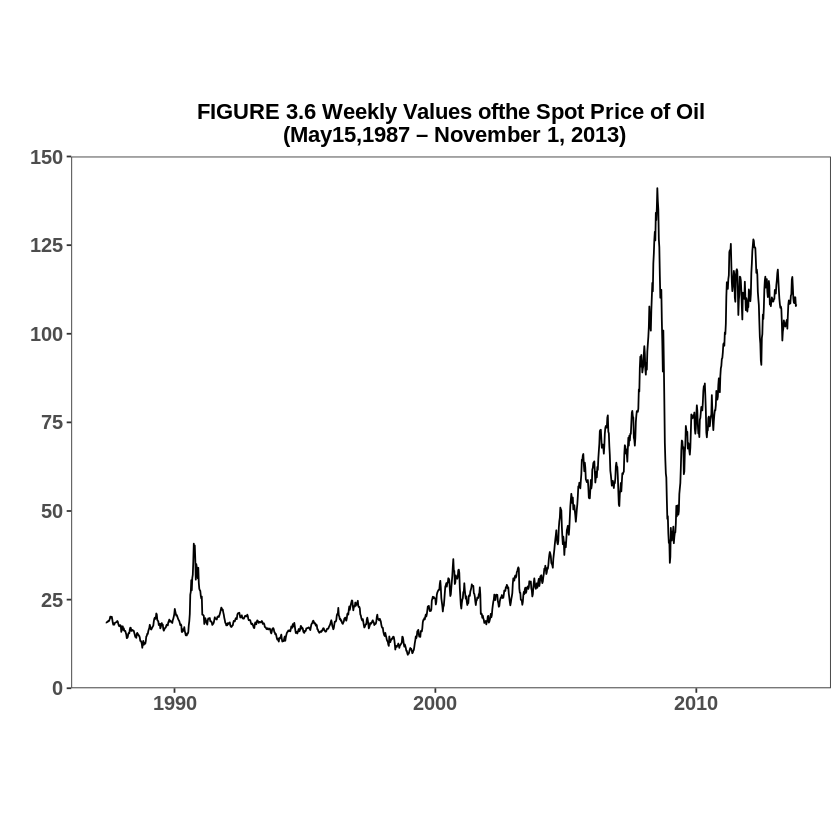

In [44]:
ggplot(oil, aes(x=Date, y = Spot))+

  geom_line()+
 
  scale_y_continuous(name="" ,limits = c(0,150) ,expand = c(0, 0) ,breaks = seq(0,150,25))+
  labs(x = "" ,y = "" ,title = "FIGURE 3.6 Weekly Values ofthe Spot Price of Oil\n (May15,1987 – November 1, 2013)")+

 theme_bw()+
 theme(aspect.ratio = .7)+ 
 mytheme

# **3. ARCH Processes**

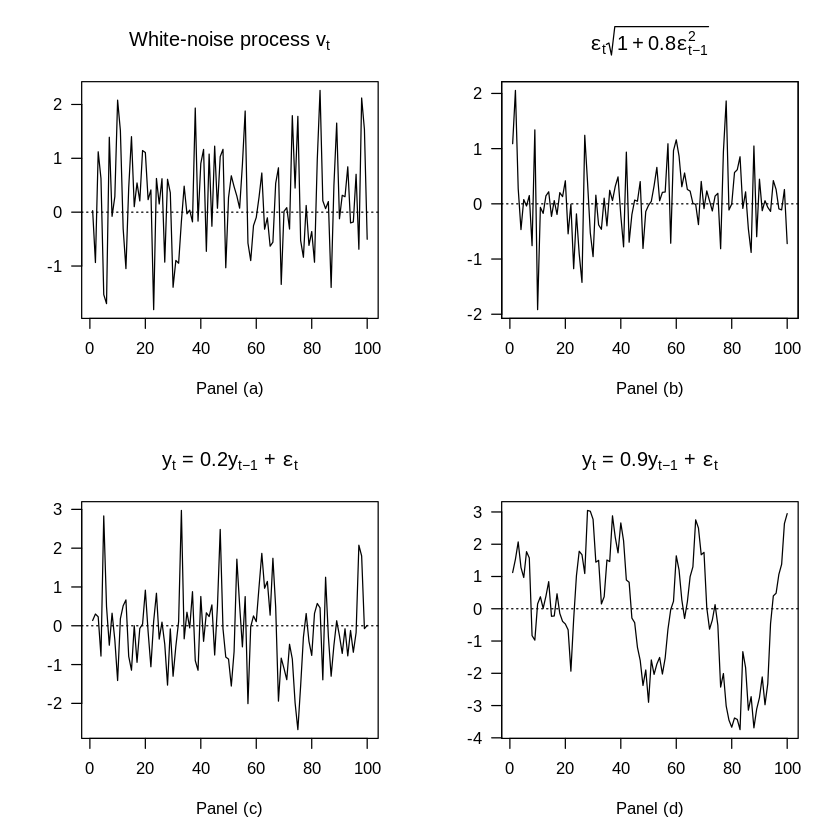

In [45]:
# FIGURE 3.7 Simulated ARCH Processes

panel.a <- ts(rnorm(100))
panel.b <- garchxSim(100, arch = 0.8, garch = 0)
panel.c <- arima.sim(n = 100, list(ar = .2))
panel.d <- arima.sim(n = 100, list(ar = .9))

par(mfrow = c(2,2), las=1)

plot(panel.a, main = expression(paste("White-noise process ",plain(v[t]))),
      ylab = "" ,xlab = "Panel (a)")
abline(h=0, lty= 3)

plot(panel.b, main = expression(paste(epsilon[t]*sqrt(1 + 0.8*epsilon[t-1]^2))),
      ylab = "" ,xlab = "Panel (b)")
abline(h=0, lty= 3)

plot(panel.c, main = expression(paste(y[t]," = " ,plain(0.2*y[t-1]) ," + ",epsilon[t])),
      ylab = "" ,xlab = "Panel (c)")
abline(h=0, lty= 3)

plot(panel.d, main = expression(paste(y[t]," = " ,plain(0.9*y[t-1]) ," + ",epsilon[t])),
      ylab = "" ,xlab = "Panel (d)")
abline(h=0, lty= 3)

# **4. Three Examples of GARCH Models**

## **4.1. A GARCH Model of Oil Prices**

Warning message:
“Removed 2 rows containing missing values (geom_hline).”


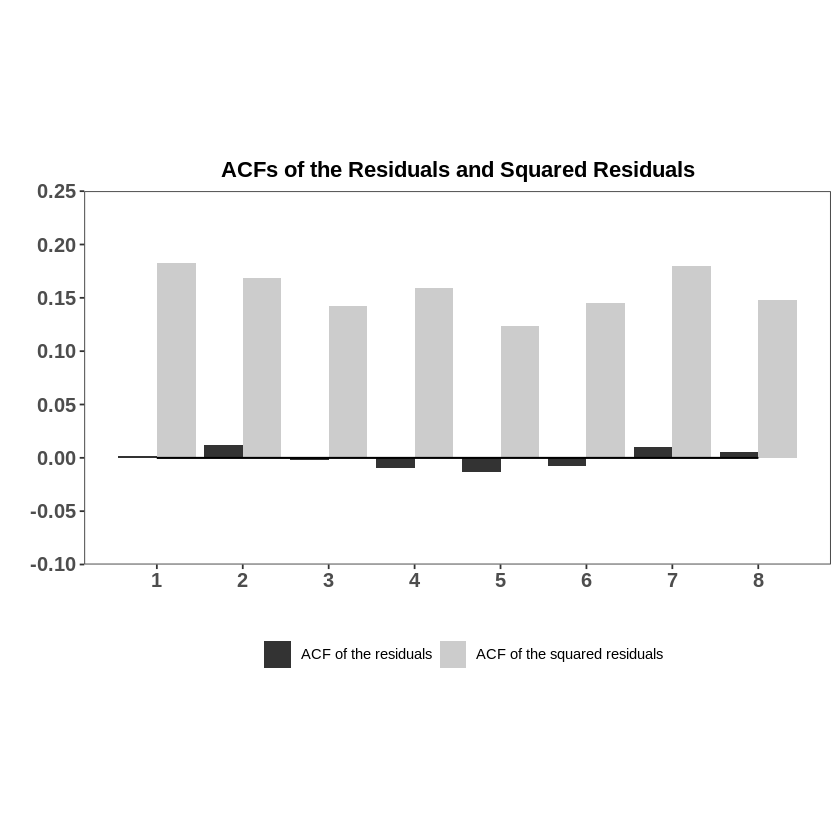

In [46]:
# ARMA model residuals diagnostics
 
oil.arma <- arima(100*diff(log(oil$Spot)), c(0,0,3), fixed = c(NA,0,NA,NA))
oil.arma$coef[2] <- NA
 
res <- oil.arma$residuals
sq.res <- res^2
 
myacf(list(res,sq.res),
      aspect.ratio = .5,
      y.breaks = seq(-.1,.25,.05),
      data.name =c("ACF of the residuals","ACF of the squared residuals"),
      gtheme = mytheme,
      title = "ACFs of the Residuals and Squared Residuals")

In [47]:
# ARMA model residuals diagnostics (contiued)

res.ar <- dynlm(sq.res ~ L(sq.res,1) + L(sq.res,2) + L(sq.res,3) + L(sq.res,4))

print(screenreg(list(oil.arma,res.ar),
                 omit.coef = "(ma2)",

                 include.nobs = F,
                 include.loglik = F,
                 include.aic=F,
                 include.bic=F,
                 include.rsquared = F,
                 include.pseudors = F,
                 include.adjrs = F,
                 include.fstatistic=T,

                 custom.gof.names = "F statistic\n(Variance model)",
                 custom.model.names = c("Mean Eq.", "Variance Eq."),
                 custom.coef.names = c("\U03B8\u2081","\U03B8\u2083","\u03BC",
                                        "\U03C9","\U03B2\u2081","\U03B2\u2082",
                                        "\U03B2\u2083","\U03B2\u2084"),
                 reorder.coef = c(3,1,2,4,5,6,7,8),
                 
                 groups = list("Mean Equation" = 1:3, "Variance Equation" = 4:8)
                 )
)


                              Mean Eq.   Variance Eq.
-----------------------------------------------------
Mean Equation                                        
                                                     
    μ                          0.13                  
                              (0.14)                 
    θ₁                         0.18 ***              
                              (0.03)                 
    θ₃                         0.09 ***              
                              (0.03)                 
Variance Equation                                    
                                                     
    ω                                     9.68 ***   
                                         (1.23)      
    β₁                                    0.13 ***   
                                         (0.03)      
    β₂                                    0.11 ***   
                                         (0.03)      
    β₃                     

In [48]:
# Alterntive model of oil price - GARCH model
 
oil.garch <- rugarch::ugarchspec(variance.model = list(garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(0,1), include.mean = TRUE),
                    )
oil.garch <- ugarchfit(oil.garch,100*diff(log(oil$Spot)))
 
# NOTE: The order of a GARCH model within rugarch is specified as (q,p) NOT (p,q).
 
print(screenreg(extract.rugarch(oil.garch,F,F,F),
                custom.coef.names = c("\u03BC","\U03B2\u2081","\U03C9",
                                        "\U03B1\u2081","\U03B2\u2081"),
                 
                 custom.model.names = "Oil price model",
                 reorder.coef = c(1,2,4,5,3),
                 groups = list("Mean Equation" = 1:2, "Variance Equation" = 3:5),
                 digits = 3
                 )
      )


                   Oil price model
----------------------------------
Mean Equation                     
                                  
    μ               0.130         
                   (0.111)        
    β₁              0.225 ***     
                   (0.028)        
Variance Equation                 
                                  
    ω               0.401 **      
                   (0.136)        
    α₁              0.097 ***     
                   (0.014)        
    β₁              0.882 ***     
                   (0.017)        
*** p < 0.001; ** p < 0.01; * p < 0.05


Warning message:
“Removed 2 rows containing missing values (geom_hline).”


Ljung-Box test for remaining serial correlation in the standarized residuals

  statistic p.value
1      2.76   0.598
2      4.88   0.770
3      8.00   0.785

for standarized squared residuals

  statistic p.value
1   0.07656  0.9993
2   1.35752  0.9948
3   6.16059  0.9078


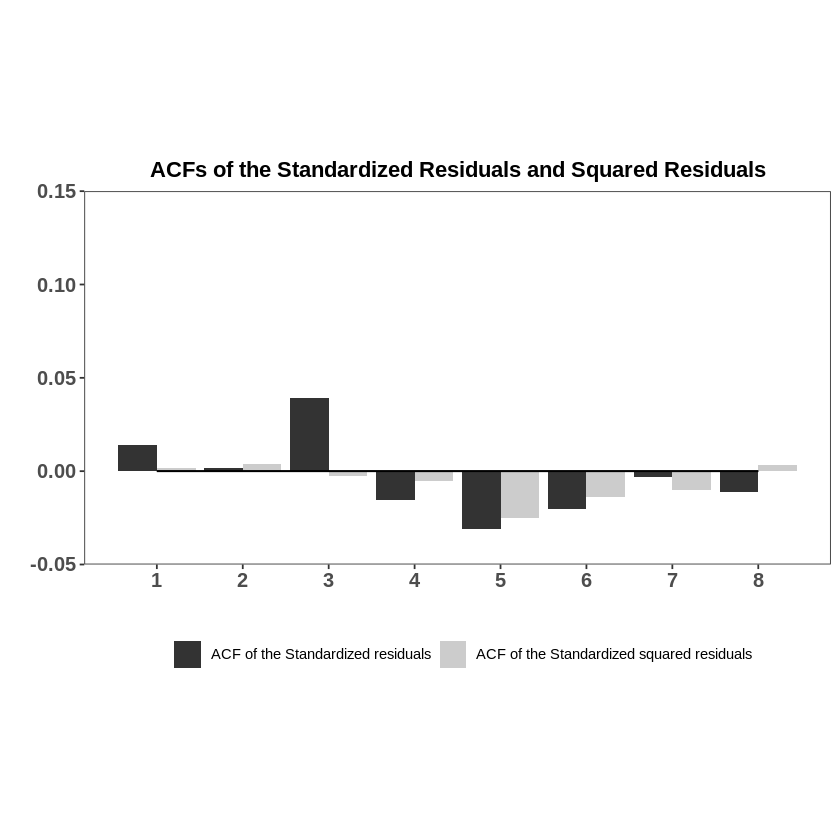

In [49]:
# GARCH model Standardized residuals diagnostics
 
  # NOTE 1: Dr. Enders stated that "The diagnostics on the standardized residuals [in the book] are wrong 
          # although the squared residuals are correct."
 
  # NOTE 2: Ljung-Box test conducted manually. ugarchfit reports the test automatically.
 
std.res <- oil.garch@fit$z
std.sq.res <- oil.garch@fit$z^2 # or manually <- oil.garch@fit$residuals^2/oil.garch@fit$sigma^2
 
myacf(list(std.res,std.sq.res),
      aspect.ratio = .5,
      y.breaks = seq(-.05,.15,.05),
      data.name =c("ACF of the Standardized residuals","ACF of the Standardized squared residuals"),
      gtheme = mytheme,
      title = "ACFs of the Standardized Residuals and Squared Residuals")
 
cat("Ljung-Box test for remaining serial correlation in the standarized residuals\n\n")
print(lb.test(std.res), digits = 3)
cat("\nfor standarized squared residuals\n\n")
print(lb.test(std.sq.res), digits = 4)

Warning message:
“Removed 2 rows containing missing values (geom_hline).”


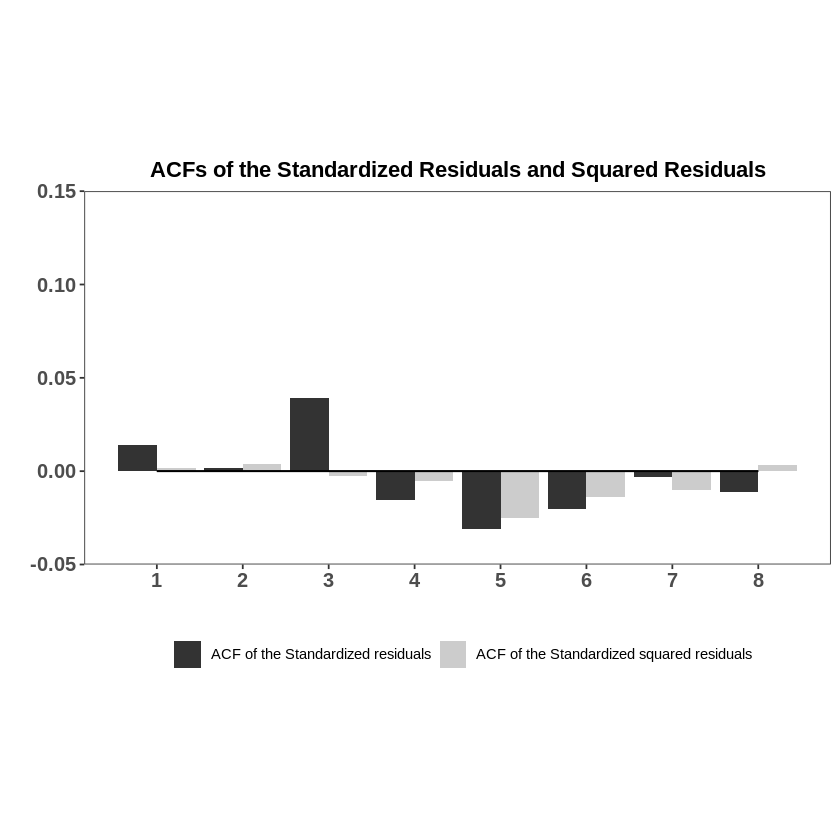

In [50]:
myacf1 <- function(data.list, h = 8,y.breaks = seq(-.5,1,.25) ,
                  aspect.ratio = 1  ,title="",data.name=c("ACF1","ACF2") ,gtheme = theme()) {
  
  # Organizing Data
  
  acfs <- data.list
  acfs <- lapply(acfs,forecast::Acf,lag.max= h ,plot=F)
  acf1 <- cbind(cbind(acfs[[1]]$acf),data.name[1])
  acf2 <- cbind(cbind(acfs[[2]]$acf),data.name[2])
  acfs <- data.frame(rep(0:h,2),rbind(acf1,acf2))
  
  names(acfs) <- c("lag","acf","type")
  acfs <- acfs[-c(1,h+2),]
  
  twose <- c(2/sqrt(length(acf1)),- 2/sqrt(length(acf1)))

  # Plot Spec.
  
  ggplot(acfs ,aes(x = lag ,y = as.numeric(acf) ,fill = type))+
    geom_hline(yintercept=twose,linetype=2,color = "blue")+
    geom_bar(position = "dodge", stat = "identity")+
    scale_fill_grey(start = 0.2, end = 0.8) +
    labs(fill = "" ,y = "" ,x = "" ,title = title)+
    scale_x_continuous(breaks = c(0:h+1))+
    scale_y_continuous(breaks = y.breaks ,limits = c(y.breaks[1],y.breaks[length(y.breaks)]) ,
                       expand = c(0, 0))+
    theme_bw()+
    geom_line(y = 0)+
    theme(aspect.ratio = aspect.ratio)+
    gtheme
}

myacf1(list(std.res,std.sq.res),
      aspect.ratio = .5,
      y.breaks = seq(-.05,.15,.05),
      data.name =c("ACF of the Standardized residuals","ACF of the Standardized squared residuals"),
      gtheme = mytheme,
      title = "ACFs of the Standardized Residuals and Squared Residuals")

## **4.2 Volatility Moderation**

In [51]:
#@title
dgdp <- diff(log(real$RGDP))
 
gdp.ar <- arima(dgdp,c(1,0,0))
gdp.res <- gdp.ar$residuals
gdp.sq.res <- gdp.res^2
gdp.q <- lb.test(gdp.res)
 
real$dummy <- 1
real$dummy[1:which(real$DATE=="1983-10-01")] <- 0
 
gdp.sq.res.ar <- dynlm(gdp.sq.res ~ L(gdp.sq.res,1) + L(gdp.sq.res,2) + L(gdp.sq.res,3) + L(gdp.sq.res,4))
 
print(screenreg(list(gdp.ar,gdp.sq.res.ar),digits = 3,
 
                 include.nobs = F,
                 include.loglik = F,
                 include.aic=F,
                 include.bic=F,
                 include.rsquared = F,
                 include.pseudors = F,
                 include.adjrs = F,
                 include.fstatistic=T,
 
                 custom.gof.names = "F statistic\n(Variance model)",
                 custom.model.names = c("Mean Eq.", "Variance Eq."),
                 custom.coef.names = c("\U03D5\u2081","\u03BC",
                                        "\U03C9","\U03B2\u2081","\U03B2\u2082",
                                        "\U03B2\u2083","\U03B2\u2084"),
                 reorder.coef = c(2,1,3,4,5,6,7),
 
                 custom.gof.rows= list(
                    "Q(4)" = c(gdp.q[1,1],NA),  
                    "Q(8)" = c(gdp.q[2,1],NA),
                    "Q(12)" = c(gdp.q[3,1],NA)
                  ),
 
                 groups = list("Mean Equation" = 1:2, "Variance Equation" = 3:7)
        )
)


                              Mean Eq.    Variance Eq.
------------------------------------------------------
Mean Equation                                         
                                                      
    μ                          0.008 ***              
                              (0.001)                 
    ϕ₁                         0.370 ***              
                              (0.057)                 
Variance Equation                                     
                                                      
    ω                                      0.000 ***  
                                          (0.000)     
    β₁                                     0.116      
                                          (0.062)     
    β₂                                     0.128 *    
                                          (0.063)     
    β₃                                    -0.029      
                                          (0.063)     
    β₄   

In [52]:
gdp.garch.s <- rugarch::ugarchspec(variance.model = list(garchOrder = c(1,0),external.regressors = matrix(real$dummy)),
                                  mean.model = list(armaOrder = c(1,0), include.mean = TRUE)
                    )
 
gdp.garch <- ugarchfit(gdp.garch.s,dgdp)
gdp.garch


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,0)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.007650    0.000852   8.9788 0.000000
ar1     0.395005    0.070615   5.5938 0.000000
omega   0.000064    0.000007   8.9562 0.000000
alpha1  0.258048    0.100953   2.5561 0.010585
vxreg1  0.000000    0.000017   0.0000 1.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.007650    0.000899   8.5057 0.000000
ar1     0.395005    0.076670   5.1520 0.000000
omega   0.000064    0.000009   6.8734 0.000000
alpha1  0.258048    0.134028   1.9253 0.054189
vxreg1  0.000000    0.000042   0.0000 1.000000

LogLikelihood : 867.5308 

Information Criteria
------------------------------------
                

# (To be continued soon)